# Prediction of Kuramoto Sivashinsky Equation Using Reservoir Computing
Apr 21, 2019. Guorui Shen, guorui233@outlook.com

This notebook is intended to predict KS system, using reservoir computing techniques. Sturcture of adopted network is
\begin{eqnarray}
r(t+\Delta t) = (1-\alpha)\cdot r(t) + \alpha\cdot\text{tanh}\big(r(t)\cdot W_r^r + u(t)\cdot W_{in}^r + b_{in}\big),\\
y(t+\Delta t) = r(t+\Delta t)\cdot W_r^{out} + u(t)\cdot W_{in}^{out} + b_{out},
\end{eqnarray}
where $u(t), r(t), y(t), b_{in}, b_{out}$ are all row vectors, only $W_i^{out}, i=r, in,$ and $b_{out}$ are to be trained via Ridge regression, the remaning unknown weights and biases are assigned random values and no update.

Feature and label are chosen as 
\begin{eqnarray}
u(t) = u({\bf x},t),\\
y(t+\Delta t) = u({\bf x}, t+\Delta t),
\end{eqnarray}
respectively, where ${\bf x} = \Big(x_1, x_2, \cdots, x_N\Big)^T$ and KS equation is given by
\begin{eqnarray}
\begin{aligned}
u = u(x,t),\\
u_t=-uu_x-u_{xx}-u_{xxxx}.
\end{aligned}
\end{eqnarray}

In [1]:
from reservoir import Reservoir
import scipy.io as sio
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [2]:
ks = sio.loadmat('KS.mat')
print ks['uu'].shape, ks['x'].shape, ks['tt'].shape

(801, 128) (128, 1) (1, 801)


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,u't')

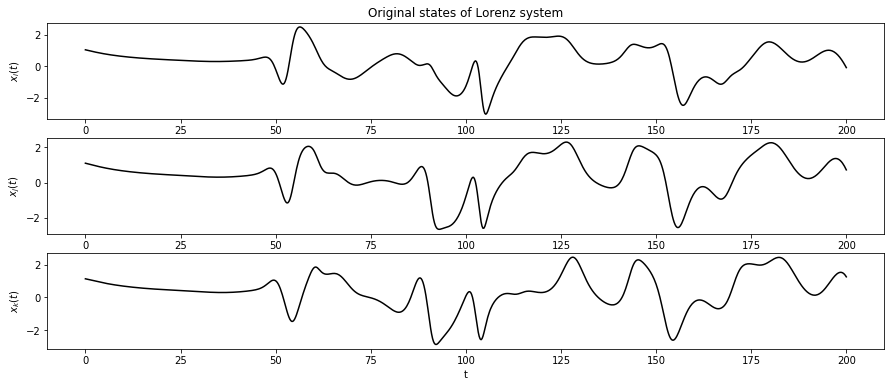

In [3]:
ylabel = ['$x_i(t)$', '$x_j(t)$', '$x_k(t)$']
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.title('Original states of Lorenz system')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(ks['tt'][0], ks['uu'][:, i], 'k-')
    plt.ylabel(ylabel[i])
plt.xlabel('t')

In [4]:
# parameters for choosing training data
train_start = 200   # discard first "train_start" steps
train_end = 700
num_pre_steps = 50 # forward predictions steps
num_init = 200

# training data
features = ks['uu'][train_start:train_end, :]
labels = ks['uu'][train_start+1:train_end+1, :]
print labels.shape

(500, 128)


In [5]:
np.random.seed(35)
# seeds tested from 1 to 40, (seed, predicted distance), (35,8422) (22, 8835) (14, 8913) (1,9717)

In [6]:
# parameters of networks
dim_in = len(features[0]) # dimension of input
dim_r = 500               # dimension of reservoir
dim_out = len(labels[0])  # dimension of output
lam = .00001 # regression parameter

In [7]:
# build a reservoir model for KS equation
ks_reservoir =  Reservoir(dim_in, dim_r, dim_out, alpha=.3, spectral_radius=1.25)

# train the model
ks_reservoir.train(features, labels, num_init, lam)

# predict future states
u = ks['uu'][train_end, :]
states_predict = np.zeros((num_pre_steps, dim_out))
for t in range(num_pre_steps):
    states_predict[t, :] = ks_reservoir.predict(u)
    u = states_predict[t, :]

Prediction error: 8422.796323099608


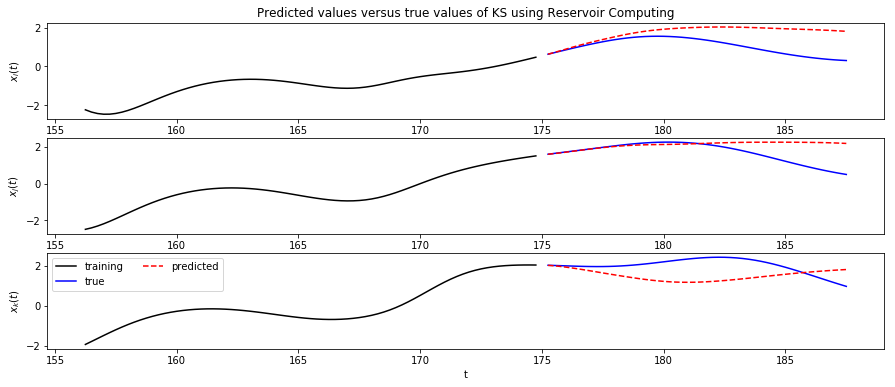

In [8]:
# visualize prediction results
t_test = ks['tt'][0][train_end+1:train_end+1+num_pre_steps]
states_test = ks['uu'][train_end+1:train_end+1+num_pre_steps, :]

t_train = ks['tt'][0][train_end-int(1.5*num_pre_steps):train_end]
states_train = ks['uu'][train_end-int(1.5*num_pre_steps):train_end, :]
print "Prediction error:",sum(sum(np.square(states_predict - states_test)))/num_pre_steps*dim_out

plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.title('Predicted values versus true values of KS using Reservoir Computing')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(t_train, states_train[:, i], 'k-', t_test, states_test[:, i], 'b-', t_test, states_predict[:, i], 'r--')
    plt.ylabel(ylabel[i])
plt.xlabel('t')
plt.legend(["training", "true", "predicted"], loc = 0, ncol = 2)

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(track1[:,0], track1[:,1], track1[:,2])
ax.plot(track2[:,0], track2[:,1], track2[:,2])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()

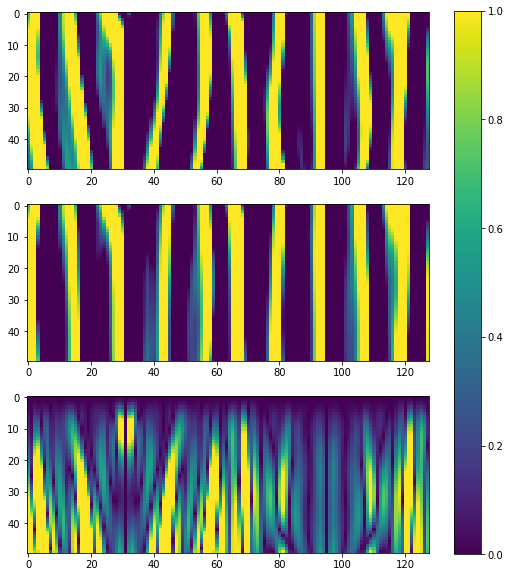

In [33]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9, 10))
axlist = [ax1,ax2,ax3]

first = ax1.imshow(states_test, vmin=0, vmax=1)
second = ax2.imshow(states_predict, vmin=0, vmax=1)
third = ax3.imshow(abs(states_predict-states_test), vmin=0, vmax=1)
fig.colorbar(first, ax=axlist)
